## Task 4: Optimize Portfolio Based on Forecast
This notebook optimizes a portfolio of TSLA, BND, and SPY using forecasts from Task 3. We'll:
- Forecast future prices for all assets.
- Combine into a single DataFrame.
- Optimize weights to maximize Sharpe Ratio.
- Analyze and visualize portfolio performance.

In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import modules
from src.data_loader import DataLoader
from src.data_preprocessor import DataPreprocessor
from src.forecaster import Forecaster
from src.portfolio_optimizer import PortfolioOptimizer
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
# Load historical data
loader = DataLoader(['TSLA', 'BND', 'SPY'])
raw_data = loader.load_data()
preprocessor = DataPreprocessor(raw_data)
cleaned_data = preprocessor.clean_data()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed
c:\Users\Temp\Desktop\KAI-Projects\Time-Series-Forecasting-for-Portfolio-Management-Optimization\src\data_loader.py:42: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  self.data = self.data.stack(level=1).reset_index().rename(


## Step 1: Forecast Future Prices
Forecast 252 trading days for TSLA, BND, and SPY using ARIMA.

In [5]:
# Forecast for each asset
tickers = ['TSLA', 'BND', 'SPY']
forecasts = {}
combined_index = None

In [6]:
for ticker in tickers:
    ticker_data = cleaned_data[cleaned_data['Ticker'] == ticker].set_index('Date')
    ticker_data = ticker_data['Close'].drop_duplicates()  # Remove duplicate dates
    forecaster = Forecaster(ticker_data.reset_index(), ticker=ticker, test_size=0.2)
    forecast, _ = forecaster.forecast_arima(optimize=True, steps=252)
    combined_series = pd.concat([ticker_data, forecast])
    forecasts[ticker] = combined_series
    if combined_index is None:
        combined_index = combined_series.index
    else:
        combined_index = combined_index.union(combined_series.index)

c:\Users\Temp\Desktop\KAI-Projects\Time-Series-Forecasting-for-Portfolio-Management-Optimization\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Temp\Desktop\KAI-Projects\Time-Series-Forecasting-for-Portfolio-Management-Optimization\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Temp\Desktop\KAI-Projects\Time-Series-Forecasting-for-Portfolio-Management-Optimization\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Temp\Desktop\KAI-Projects\Time-Series-Forecasting-for-Portfolio-Management-Optimization\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'f

In [7]:
# Combine into one DataFrame with unique index
df = pd.DataFrame(index=combined_index)
for ticker in tickers:
    df[ticker] = forecasts[ticker].reindex(combined_index)

## Step 2: Portfolio Optimization
Optimize weights to maximize Sharpe Ratio.

In [8]:
# Initialize PortfolioOptimizer with forecast data
optimizer = PortfolioOptimizer(df)

c:\Users\Temp\Desktop\KAI-Projects\Time-Series-Forecasting-for-Portfolio-Management-Optimization\src\portfolio_optimizer.py:26: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.returns = self.forecasts.pct_change().dropna()


In [9]:
# Optimize weights
optimal_weights = optimizer.optimize_sharpe(risk_free_rate=0.02)
print("Optimal Weights:")
print(optimal_weights)

Optimal Weights:
TSLA    5.895548e-01
BND     1.456933e-07
SPY     4.104451e-01
dtype: float64


In [10]:
# Compute portfolio performance
metrics, portfolio_returns = optimizer.portfolio_performance(optimal_weights, risk_free_rate=0.02)
print("Portfolio Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

Portfolio Metrics:
Return: 0.3381
Volatility: 0.3986
Sharpe Ratio: 0.7981
VaR (95%): -0.5398


# Markdown
## Step 3: Visualize Portfolio Performance
Plot cumulative returns and risk-return analysis.

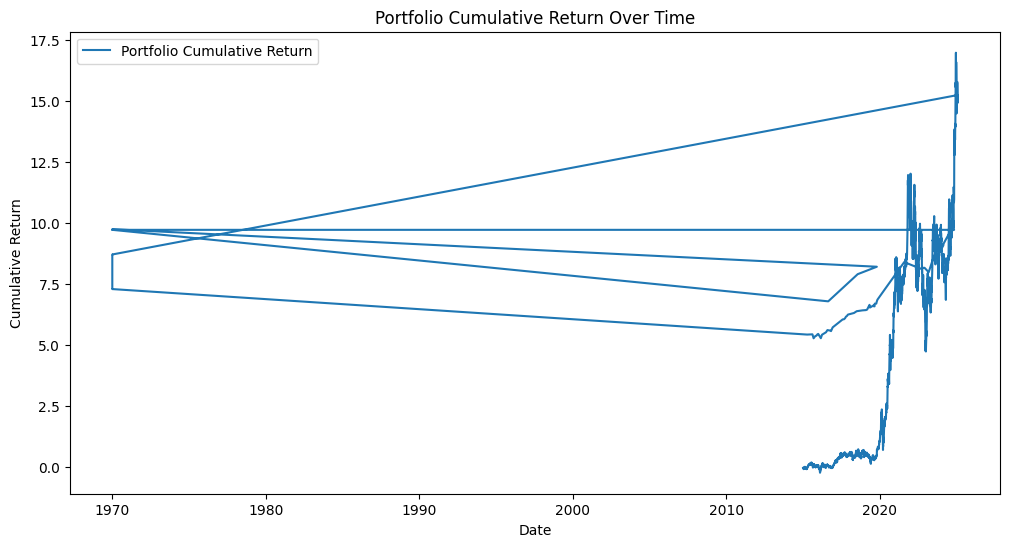

In [11]:
# Cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod() - 1
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns, label='Portfolio Cumulative Return')
plt.title('Portfolio Cumulative Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.savefig('../notebooks/portfolio_cumulative_return.png')
plt.show()

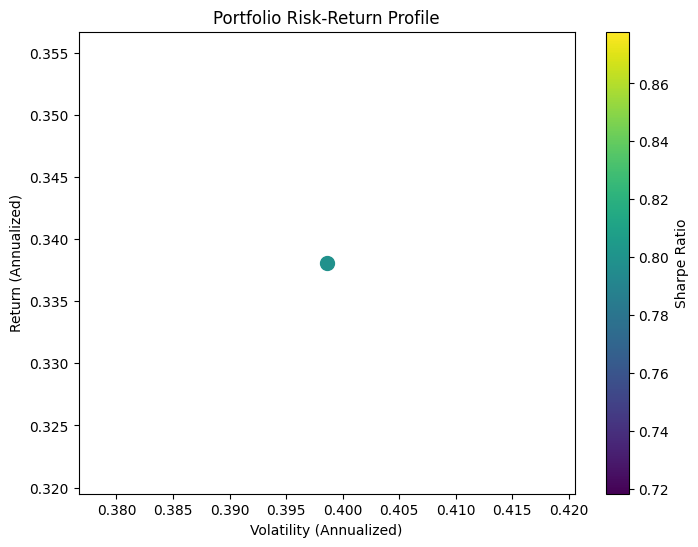

In [12]:
# Risk-return scatter (hypothetical for illustration)
plt.figure(figsize=(8, 6))
plt.scatter(metrics['Volatility'], metrics['Return'], c=metrics['Sharpe Ratio'], cmap='viridis', s=100)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Annualized)')
plt.ylabel('Return (Annualized)')
plt.title('Portfolio Risk-Return Profile')
plt.savefig('../images/portfolio_risk_return.png')
plt.show()

## Step 4: Summary and Adjustments
- **Expected Return**: Annualized portfolio return.
- **Volatility**: Standard deviation of returns.
- **Sharpe Ratio**: Risk-adjusted return.
- **Adjustments**: 
  - TSLA: High risk, adjust based on forecast decline.
  - BND: Increase if volatility rises.
  - SPY: Balance for diversification.
- **Reasoning**: Based on TSLA’s forecasted decline, favor stability (BND) and diversification (SPY).